## Imports and Functions

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# imputation
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

In [144]:
def clean_col(col_name):
    '''
    Rename columns to be more Pythonic:
    - lowercase
    - underscore between words
    - replace some language with more descriptive examples
    
    Return revised column name.
    '''
    col_name = col_name.lower()
    col_name = col_name.replace('pct','_pct')
    col_name = col_name.replace('state','st')
    col_name = col_name.replace('acstot','')
    col_name = col_name.replace('minor','poc')
    col_name = col_name.replace('less','sub_')
    col_name = col_name.replace('lowinc','low_inc')
    col_name = col_name.replace('ling','ling_')
    col_name = col_name.replace('under5','under_5')
    col_name = col_name.replace('over64','over_64')
    col_name = col_name.replace('vuleo_pct','dem_index')
    col_name = col_name.replace('pre1960','pre_1960')
    col_name = col_name.replace('ptraf','traffic_prox')
    col_name = col_name.replace('dslpm','diesel_pm')
    col_name = col_name.replace('pnpl','npl_prox')
    col_name = col_name.replace('prmp','rmp_prox')
    col_name = col_name.replace('ptsdf','waste_prox')
    col_name = col_name.replace('resp','resp_index')
    col_name = col_name.replace('pwdis','waste_water')
    col_name = col_name.replace('25','_25')
    col_name = col_name.replace('ust','undgrd_stor')
    
    return col_name
    

---
## Basic Cleaning

In [145]:
raw_data = pd.read_csv('./EJSCREEN_2021_StatePctile_Tracts.csv')

C:\Users\Vishnu\AppData\Local\Temp\ipykernel_12692\2832420063.py:1: DtypeWarning: Columns (128,129,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('./EJSCREEN_2021_StatePctile_Tracts.csv')


Columns beginning with `B_` and `T_` provide information for creating specialized images. This is not necessary for our exploratory data analysis so we will drop these columns. Columns beginning with `P_` and `D_` contain percentile and index data. These can be reconstructed from other columns without much difficulty, so we will drop these as well.

There is also identification and shape data that we do not need for eda. These columns are located in the first two and last two columns. We will drop these columns, too.

In [146]:
# initial columns of interest
# cut columns related to image data, clean the rest
init_cols = [col for col in raw_data.columns if col[:2] not in 'P_B_T_D_']

# drop OBJECTID - repeated index col
# drop Shape cols
init_cols = init_cols[2:-2]
init_cols

['STATE_NAME',
 'ST_ABBREV',
 'REGION',
 'ACSTOTPOP',
 'MINORPCT',
 'LOWINCPCT',
 'LESSHSPCT',
 'LINGISOPCT',
 'UNDER5PCT',
 'OVER64PCT',
 'UNEMPPCT',
 'VULEOPCT',
 'PRE1960PCT',
 'DSLPM',
 'CANCER',
 'RESP',
 'PTRAF',
 'PWDIS',
 'PNPL',
 'PRMP',
 'PTSDF',
 'OZONE',
 'PM25',
 'UST']

Below we change the column labels to lower case and include an underscore to between the `PCT` (representing percent) to make the columns a bit more readable.

In [147]:
env = raw_data[init_cols].copy()
env.columns = [clean_col(col) for col in env.columns]

To check the results, we list out the revised column names.

In [148]:
env.columns

Index(['st_name', 'st_abbrev', 'region', 'pop', 'poc_pct', 'low_inc_pct',
       'sub_hs_pct', 'ling_iso_pct', 'under_5_pct', 'over_64_pct', 'unemp_pct',
       'dem_index', 'pre_1960_pct', 'diesel_pm', 'cancer', 'resp_index',
       'traffic_prox', 'waste_water', 'npl_prox', 'rmp_prox', 'waste_prox',
       'ozone', 'pm_25', 'undgrd_stor'],
      dtype='object')

There are few hundred rows of data where the numeric entries consist entirely of zeros or missing values. These rows will be impossible to work with and should be removed.

In [149]:
# drop rows containing no information (consisting of ALL zeros and nulls)

# identify location of first and last numeric columns
pop_index = env.columns.get_loc('pop')
stor_index = env.columns.get_loc('undgrd_stor')

# count nulls within a row
nulls_in_row = env.iloc[:,pop_index:stor_index+1].isnull().sum(axis = 1)
# count zeros within a row
zeros_in_row = (env.iloc[:,pop_index:stor_index+1] == 0).sum(axis = 1)

# if zeros and nulls sum to number of numeric columns, drop the row
total_num_cols = env.iloc[:,pop_index:stor_index+1].shape[1]
env.drop(index = env[nulls_in_row + zeros_in_row == total_num_cols].index, inplace = True)

One of our major goals is to predict the air toxics cancer risk given by the `cancer` column. Since this column is especially valuable to us, we want to avoid imputing missing values within it. Below we see it contains 246 missing values.

In [150]:
env.isnull().sum()

st_name             0
st_abbrev           0
region              0
pop                 0
poc_pct             0
low_inc_pct         0
sub_hs_pct          0
ling_iso_pct        0
under_5_pct         0
over_64_pct         0
unemp_pct           0
dem_index           0
pre_1960_pct        0
diesel_pm         246
cancer            246
resp_index        246
traffic_prox     2343
waste_water     19644
npl_prox            0
rmp_prox            0
waste_prox          0
ozone            1383
pm_25            1383
undgrd_stor         0
dtype: int64

Before we drop the rows missing `cancer` data, we check to see if the entries seem genuinely random and that we are not introducing any blatant bias to our dataset. Since the states of these entries seem reasonably distributed, it feels fair to assume they are random.

In [151]:
env.loc[env['cancer'].isna(), 'st_name'].value_counts()

New York          31
Florida           26
California        18
Texas             16
Michigan          13
Virginia          12
Louisiana         12
North Carolina    10
Tennessee          8
Colorado           7
Pennsylvania       7
Georgia            7
Nevada             7
South Carolina     6
Illinois           6
Arizona            6
Massachusetts      5
Kentucky           5
Mississippi        4
Maryland           4
Kansas             4
New Hampshire      3
Utah               3
Ohio               3
Oregon             3
Washington         3
Wisconsin          3
New Jersey         2
Iowa               2
Missouri           2
Vermont            1
Alabama            1
New Mexico         1
Minnesota          1
Indiana            1
Delaware           1
Connecticut        1
Wyoming            1
Name: st_name, dtype: int64

In [152]:
env.dropna(subset = ['cancer'], inplace = True)

In [153]:
env.drop(columns = ['dem_index', 'waste_water'], inplace = True)

Conveniently, dropping the rows with missing `cancer` values coincided with rows missing `diesel_pm` and `resp_index`.

In [154]:
env.isnull().sum()

st_name            0
st_abbrev          0
region             0
pop                0
poc_pct            0
low_inc_pct        0
sub_hs_pct         0
ling_iso_pct       0
under_5_pct        0
over_64_pct        0
unemp_pct          0
pre_1960_pct       0
diesel_pm          0
cancer             0
resp_index         0
traffic_prox    2103
npl_prox           0
rmp_prox           0
waste_prox         0
ozone           1383
pm_25           1383
undgrd_stor        0
dtype: int64

Another thing to be cautious of is that several columns are based on percentages of the population. These percentages can be somewhat deceptive for rows containing lower populations. For example, 100% of the population being minority feels more meaningful when the population size is 2416 than if the population size is 8. For this reason we want to filter out rows with especially small population sizes.

Additionally, each row represents a Census tract. Census tracts generally have a population size above 1,200. Rows with a population size below 1,200 correspond to tribal data. We do not want to eliminate the tribal data, especially with the history of environmental injustice towards indigenous people. For this reason, we will set a population size of 30 as a lower bound for the data. This way, we can feel more confident in interpreting percentages and still keep as much of the tribal data as possible.

Below we verify that the data corresponding to population sizes below 30 is reasonably distributed across all states.

In [155]:
env.loc[env['pop'] <= 30, 'st_name'].value_counts()

New York          34
Florida           19
California        18
Texas             15
Pennsylvania      15
Puerto Rico       10
Virginia          10
Tennessee          9
Hawaii             8
Kansas             6
Michigan           6
North Carolina     5
Massachusetts      4
Missouri           4
Louisiana          4
Arizona            4
Ohio               3
Alabama            3
Kentucky           3
Maryland           2
New Jersey         2
Indiana            2
Georgia            2
Rhode Island       1
Washington         1
Arkansas           1
South Carolina     1
Montana            1
Idaho              1
Nebraska           1
Oklahoma           1
Alaska             1
Illinois           1
Nevada             1
Oregon             1
Name: st_name, dtype: int64

In [156]:
env = env[env['pop']>=30]

In [195]:
dem_info = env.loc[:,'pop':'unemp_pct']
env[(dem_info == 0).sum(axis = 1) < 5].shape # drop

(73134, 22)

-------------------------------------

## EDA Visulization

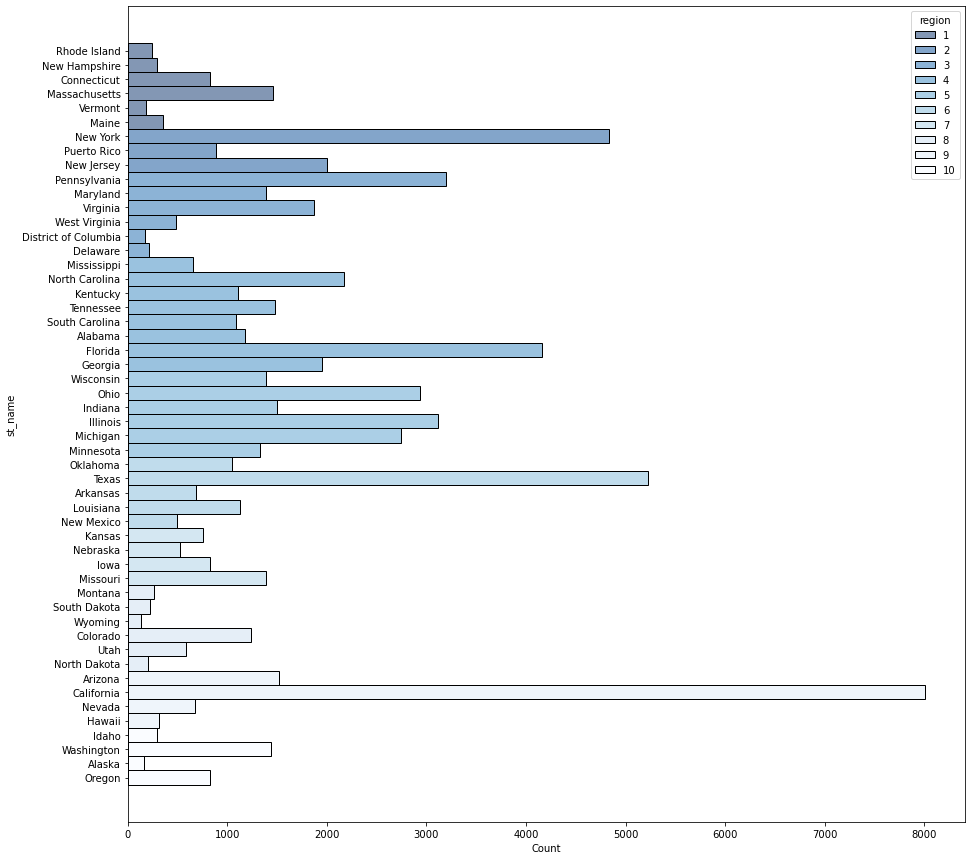

In [196]:
plt.figure(figsize = (15,15))
sns.histplot(data = env.sort_values(by = 'region'), y = 'st_name', hue = 'region', palette = 'Blues_r');
#env.groupby('region')['st_name'].value_counts().sort_values(ascending = False).plot(kind = 'barh')
#env['st_name'].value_counts().plot(kind = 'barh')


Region vs Environmnetal Factors

In [197]:
env.groupby('region')['cancer'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,23.068216,4.888427,10.0,20.0,20.0,30.0,50.0
2,7720.0,28.117876,11.432860,10.0,20.0,30.0,30.0,700.0
3,7336.0,30.845147,10.837840,20.0,30.0,30.0,30.0,200.0
4,13796.0,30.542186,6.771497,10.0,30.0,30.0,30.0,200.0
5,13035.0,24.428078,6.398433,10.0,20.0,20.0,30.0,200.0
6,8575.0,31.867055,17.937794,10.0,30.0,30.0,30.0,1000.0
7,3501.0,25.389889,6.849250,10.0,20.0,30.0,30.0,200.0
8,2655.0,21.884746,11.035681,8.0,20.0,20.0,30.0,200.0
9,10512.0,30.359494,9.670051,9.0,30.0,30.0,40.0,200.0


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


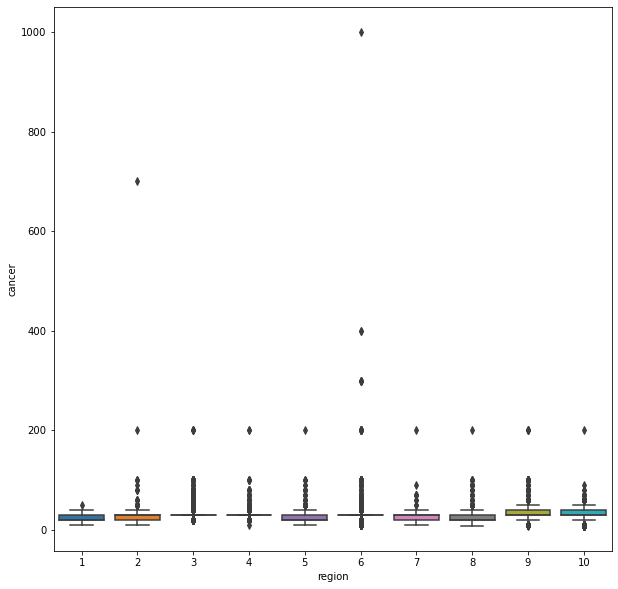

In [198]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['cancer']);

In [199]:
env.drop([73723], inplace = True)

KeyError: '[73723] not found in axis'

C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


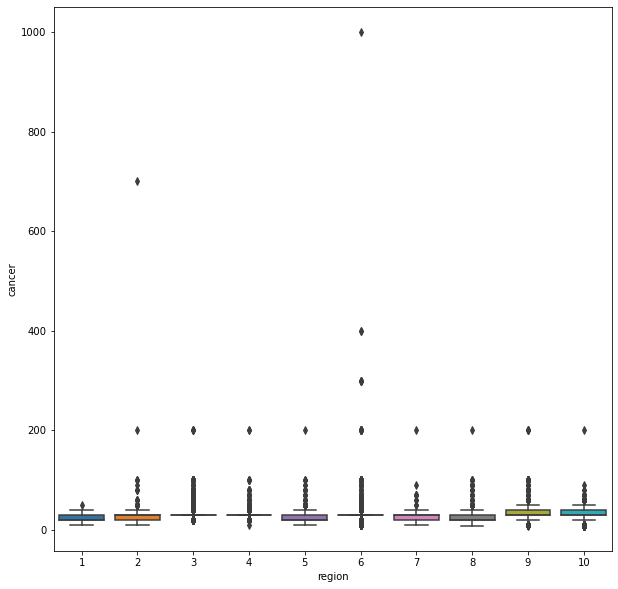

In [200]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['cancer']);

In [201]:
env.groupby('region')['diesel_pm'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,0.226067,0.166967,0.014337,0.116459,0.191493,0.277327,1.053983
2,7720.0,0.546520,0.464182,0.005776,0.171305,0.360294,0.873405,1.927320
3,7336.0,0.271259,0.131953,0.043552,0.161809,0.257579,0.368201,1.025638
4,13796.0,0.258878,0.155497,0.042090,0.132362,0.223871,0.346081,1.155929
5,13035.0,0.287581,0.191005,0.021070,0.157425,0.254062,0.370956,1.818186
6,8575.0,0.227053,0.145687,0.010226,0.115237,0.204725,0.295032,1.026167
7,3501.0,0.219458,0.133724,0.032283,0.109737,0.184288,0.294335,0.782373
8,2655.0,0.202088,0.167258,0.006761,0.056834,0.172190,0.300742,1.531864
9,10512.0,0.335886,0.189603,0.000519,0.186890,0.325176,0.472524,1.150039


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


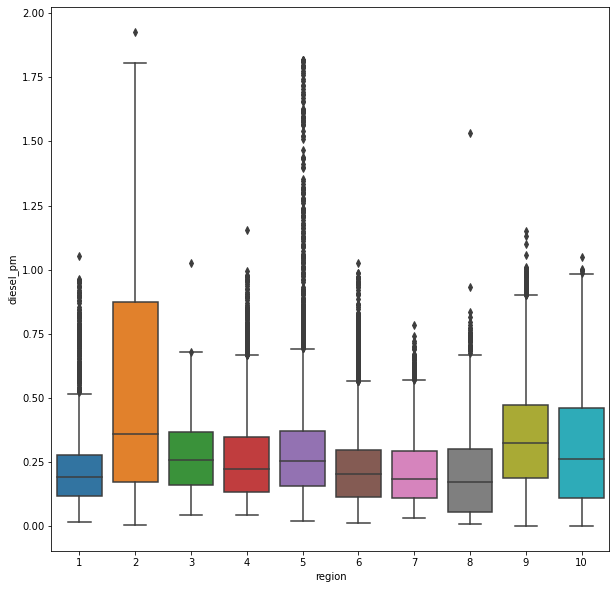

In [202]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['diesel_pm']);

In [203]:
env.groupby('region')['resp_index'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,0.275842,0.067057,0.10,0.2,0.3,0.3,0.7
2,7720.0,0.368122,0.144863,0.10,0.2,0.3,0.5,0.9
3,7336.0,0.344670,0.076148,0.20,0.3,0.3,0.4,1.0
4,13796.0,0.397434,0.090149,0.10,0.3,0.4,0.4,2.0
5,13035.0,0.301649,0.086815,0.10,0.2,0.3,0.3,2.0
6,8575.0,0.373691,0.099582,0.10,0.3,0.4,0.4,1.0
7,3501.0,0.323108,0.093718,0.10,0.2,0.3,0.4,0.7
8,2655.0,0.294603,0.201258,0.07,0.2,0.3,0.4,2.0
9,10512.0,0.406046,0.193776,0.09,0.3,0.4,0.5,4.0


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


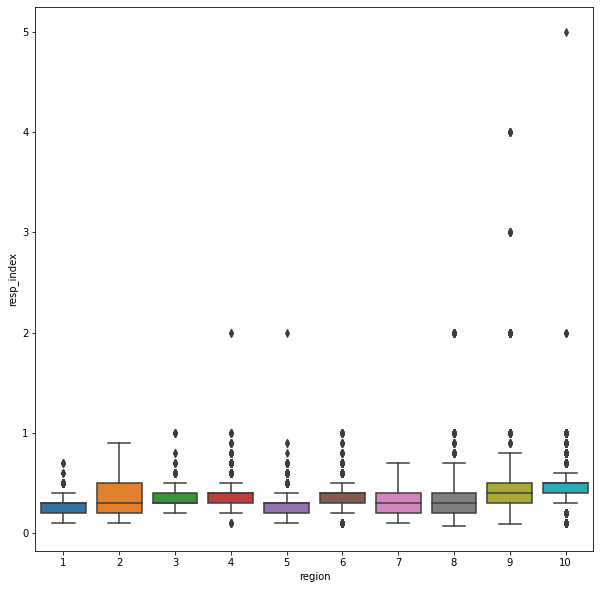

In [204]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['resp_index']);

In [205]:
env.groupby('region')['npl_prox'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,0.148498,0.215141,0.009093,0.053225,0.080969,0.141127,2.486735
2,7720.0,0.272974,0.404658,0.011798,0.074214,0.140211,0.257349,6.363388
3,7336.0,0.159773,0.277022,0.010161,0.043934,0.081809,0.157764,5.048768
4,13796.0,0.087562,0.176336,0.005681,0.016600,0.036446,0.087648,5.559691
5,13035.0,0.127770,0.238035,0.004282,0.031357,0.057234,0.116781,4.357276
6,8575.0,0.083387,0.154929,0.003554,0.017602,0.038268,0.088247,2.718384
7,3501.0,0.099986,0.171839,0.004685,0.019352,0.049258,0.110062,1.940754
8,2655.0,0.108026,0.209046,0.001986,0.012594,0.035537,0.122474,3.902370
9,10512.0,0.151237,0.383251,0.002591,0.034519,0.070647,0.140431,8.059139


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


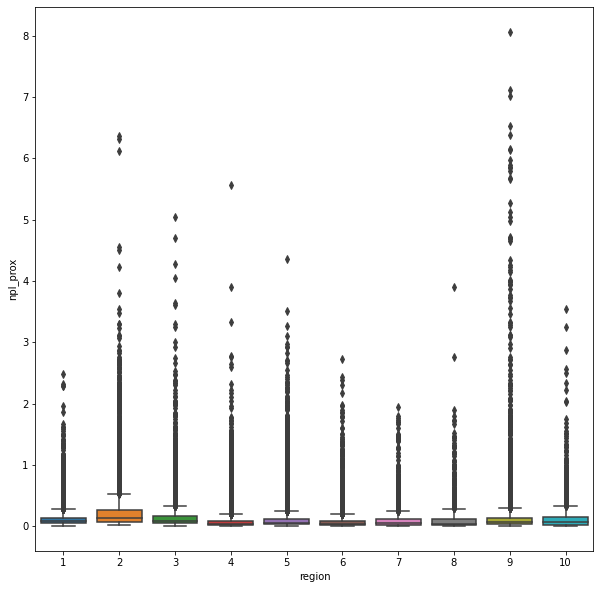

In [206]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['npl_prox']);

In [207]:
env.groupby('region')['rmp_prox'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,0.627114,0.832889,0.010558,0.112076,0.268582,0.823060,8.644721
2,7720.0,0.657790,0.920397,0.017307,0.139541,0.296897,0.807416,12.598708
3,7336.0,0.692741,0.934125,0.017727,0.133649,0.297870,0.884169,10.213013
4,13796.0,0.650873,0.912723,0.012017,0.119578,0.271187,0.820013,10.153860
5,13035.0,0.911866,1.149144,0.007896,0.173214,0.480331,1.219877,13.530489
6,8575.0,0.885095,1.208804,0.006326,0.158753,0.427368,1.151974,15.815071
7,3501.0,1.063387,1.154421,0.012358,0.229379,0.691585,1.441658,10.210545
8,2655.0,0.645403,0.808022,0.008881,0.143800,0.324704,0.848488,7.588711
9,10512.0,1.012133,1.464256,0.005603,0.182054,0.483199,1.238353,17.607654


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


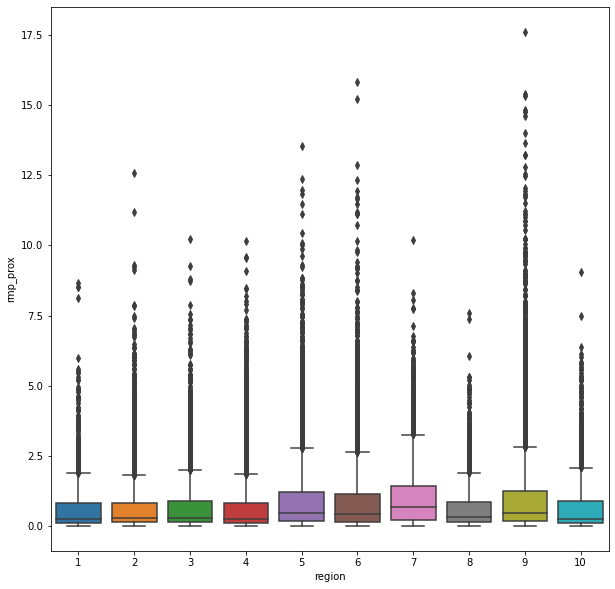

In [208]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['rmp_prox']);

In [209]:
env.groupby('region')['traffic_prox'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3222.0,1369.734995,3263.981754,0.001668,125.406449,443.629669,1294.440622,42063.593145
2,7629.0,844.734166,1230.907451,0.001149,143.718871,414.348028,1001.828629,15135.219025
3,7126.0,731.628996,1306.674450,0.000727,95.801752,335.997770,834.108525,23072.081354
4,13250.0,456.932081,923.830148,0.000410,42.836194,172.427178,511.352441,25481.534146
5,12667.0,683.484472,1186.324616,0.000630,94.179447,311.600862,778.792340,22114.272146
6,8265.0,531.263034,915.325500,0.000241,77.641233,232.216401,571.843703,13313.271626
7,3341.0,441.773827,840.764204,0.000720,37.013493,177.080107,479.181209,12819.730868
8,2594.0,511.500505,765.781108,0.000149,66.896687,268.767918,635.148714,11935.137537
9,10402.0,1350.174502,2530.574913,0.000032,121.805246,428.688108,1373.450050,34647.430696


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


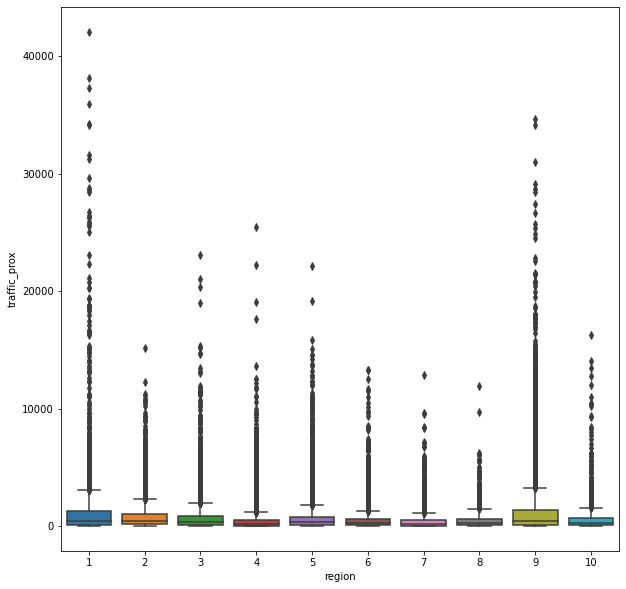

In [210]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['traffic_prox']);

In [211]:
env.groupby('region')['waste_prox'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,3.962331,6.807005,0.010797,0.408347,1.921894,4.459744,57.751593
2,7720.0,4.717458,6.434878,0.019681,0.483750,2.340819,6.232107,47.000513
3,7336.0,2.076710,3.794244,0.012833,0.183873,0.724028,2.333923,46.925941
4,13796.0,0.687424,1.106015,0.010753,0.101108,0.227139,0.797039,14.643542
5,13035.0,1.913553,2.489093,0.007322,0.205958,1.045881,2.637826,26.455067
6,8575.0,0.910102,1.307430,0.004855,0.104356,0.360134,1.194626,13.606208
7,3501.0,1.081273,1.475052,0.007000,0.068772,0.415955,1.509446,9.450530
8,2655.0,0.738265,0.941759,0.004952,0.063137,0.355191,1.076731,7.191161
9,10512.0,4.533289,4.557115,0.005430,1.143693,2.983536,6.575305,35.643179


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


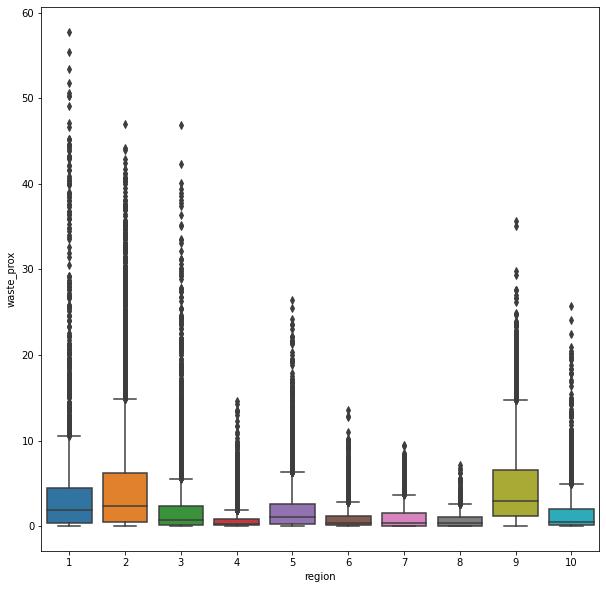

In [212]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['waste_prox']);

In [213]:
env.groupby('region')['undgrd_stor'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,3.191507,4.513291,0.0,0.380192,1.526609,4.261739,46.799733
2,7720.0,9.236194,13.271907,0.0,0.466997,3.488034,13.119708,154.788486
3,7336.0,2.917941,4.364976,0.0,0.337259,1.426891,3.694851,68.460827
4,13796.0,3.855132,6.310283,0.0,0.349804,1.562551,4.530755,81.917067
5,13035.0,5.568955,8.270690,0.0,0.530529,2.444811,7.048410,84.781368
6,8575.0,2.228575,2.494650,0.0,0.360188,1.527009,3.286078,31.114518
7,3501.0,2.770881,4.456675,0.0,0.160509,1.185027,3.594017,69.679229
8,2655.0,2.789964,4.311574,0.0,0.221216,1.416580,3.703715,78.076904
9,10512.0,3.498885,4.535379,0.0,0.597303,2.088123,4.550748,54.782787


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


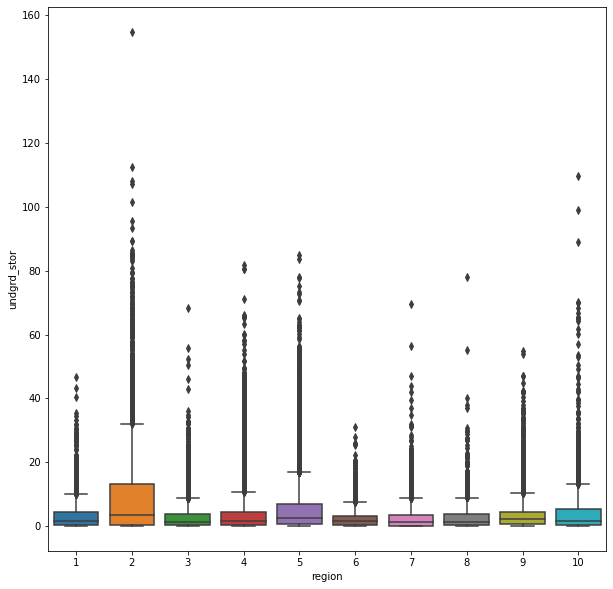

In [214]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['undgrd_stor']);

Region vs Demographic factor boxplots

In [215]:
env.groupby('region')['pop'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,4405.933870,1738.274272,32.0,3103.00,4259.0,5544.00,13198.0
2,7720.0,4114.349741,1889.078512,36.0,2734.75,3873.5,5179.25,28109.0
3,7336.0,4189.207061,1867.913015,40.0,2824.00,3944.0,5273.00,19438.0
4,13796.0,4755.624674,2586.544723,61.0,3024.00,4346.0,5952.25,39928.0
5,13035.0,4020.747219,1948.545004,32.0,2694.00,3727.0,5006.00,29089.0
6,8575.0,4892.050262,3049.525011,34.0,2968.50,4371.0,6058.50,72041.0
7,3501.0,4018.734647,1972.405778,76.0,2661.00,3660.0,4979.00,32179.0
8,2655.0,4507.052731,2485.030756,53.0,2863.00,4156.0,5631.00,46482.0
9,10512.0,4825.321728,2227.258107,31.0,3400.00,4532.0,5869.00,38754.0


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


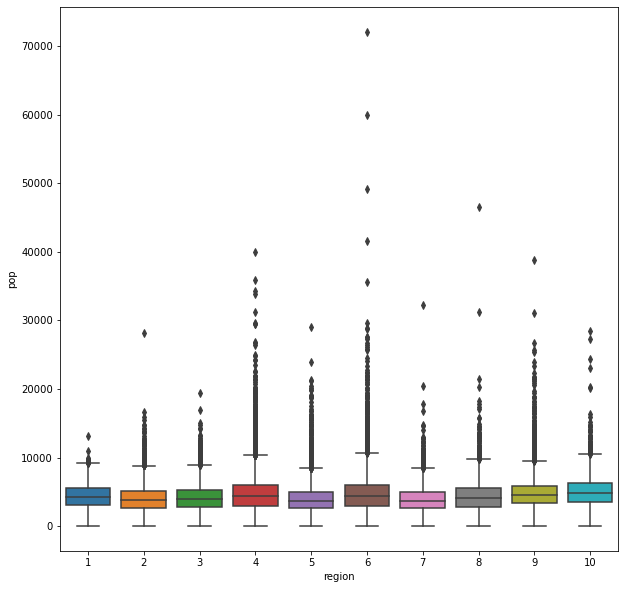

In [216]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['pop']);

In [217]:
env.groupby('region')['poc_pct'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,0.252845,0.247699,0.00000,0.071048,0.149312,0.350768,1.000000
2,7720.0,0.509903,0.353195,0.00000,0.175422,0.443389,0.904438,1.000000
3,7336.0,0.327717,0.290602,0.00000,0.085472,0.230732,0.504293,1.000000
4,13796.0,0.383142,0.281531,0.00000,0.144674,0.315469,0.576817,1.000000
5,13035.0,0.283263,0.285461,0.00000,0.069548,0.164111,0.398925,1.000000
6,8575.0,0.512756,0.279952,0.00000,0.274027,0.475126,0.760019,1.000000
7,3501.0,0.210558,0.221507,0.00000,0.061475,0.128232,0.264438,1.000000
8,2655.0,0.243526,0.196344,0.00000,0.103636,0.180891,0.323793,0.991048
9,10512.0,0.585996,0.264917,0.00000,0.357073,0.589939,0.832241,1.000000


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


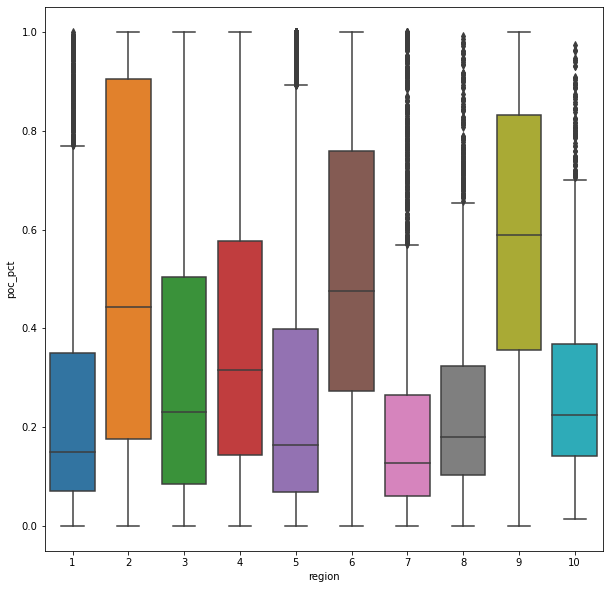

In [218]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['poc_pct']);

In [219]:
env.groupby('region')['low_inc_pct'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,0.250463,0.165572,0.0,0.124254,0.202848,0.346253,1.000000
2,7720.0,0.337552,0.231254,0.0,0.151878,0.277652,0.482324,1.000000
3,7336.0,0.285598,0.174946,0.0,0.149607,0.257366,0.387594,1.000000
4,13796.0,0.372550,0.173757,0.0,0.239655,0.365901,0.489956,1.000000
5,13035.0,0.326419,0.187255,0.0,0.182413,0.291769,0.435082,1.000000
6,8575.0,0.384228,0.184870,0.0,0.244125,0.376875,0.516715,1.000000
7,3501.0,0.325035,0.164600,0.0,0.207595,0.305213,0.424664,1.000000
8,2655.0,0.282720,0.153571,0.0,0.166192,0.263421,0.367643,1.000000
9,10512.0,0.316568,0.184451,0.0,0.165360,0.281406,0.447516,1.000000


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


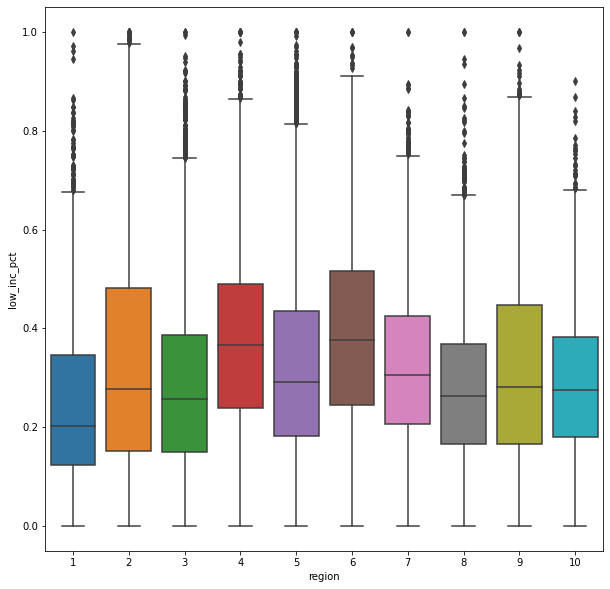

In [220]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['low_inc_pct']);

In [221]:
env.groupby('region')['sub_hs_pct'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,0.095830,0.084439,0.0,0.039526,0.068520,0.123308,0.682091
2,7720.0,0.141107,0.108308,0.0,0.058510,0.110078,0.202080,1.000000
3,7336.0,0.104290,0.077163,0.0,0.049131,0.087125,0.140071,0.816566
4,13796.0,0.134261,0.086435,0.0,0.065710,0.122087,0.188349,0.658599
5,13035.0,0.105151,0.082770,0.0,0.048840,0.083747,0.136313,0.718519
6,8575.0,0.166429,0.123381,0.0,0.073478,0.138011,0.230334,1.000000
7,3501.0,0.099734,0.076555,0.0,0.047594,0.080039,0.129673,0.559540
8,2655.0,0.081900,0.070590,0.0,0.034266,0.062393,0.107016,0.541935
9,10512.0,0.163782,0.140750,0.0,0.053873,0.115214,0.244028,0.762928


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


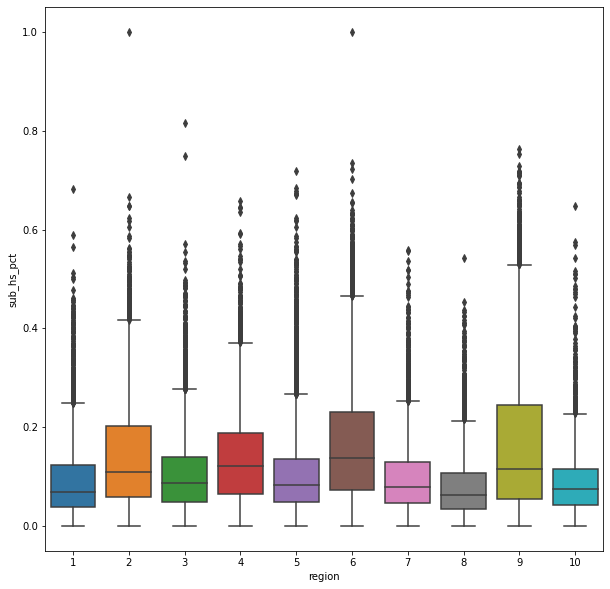

In [222]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['sub_hs_pct']);

In [223]:
env.groupby('region')['ling_iso_pct'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,0.047498,0.070564,0.0,0.003891,0.018587,0.058182,0.498041
2,7720.0,0.148595,0.221809,0.0,0.012359,0.046281,0.167791,1.000000
3,7336.0,0.025237,0.046304,0.0,0.000000,0.008727,0.029332,0.782994
4,13796.0,0.033589,0.067230,0.0,0.000000,0.010623,0.034115,1.000000
5,13035.0,0.024283,0.046511,0.0,0.000000,0.006777,0.025796,0.560000
6,8575.0,0.061817,0.092574,0.0,0.006199,0.026420,0.077331,0.788929
7,3501.0,0.019535,0.039510,0.0,0.000000,0.005928,0.021277,0.647059
8,2655.0,0.020974,0.034372,0.0,0.000000,0.008134,0.024174,0.309010
9,10512.0,0.085248,0.091191,0.0,0.020389,0.055575,0.121755,1.000000


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


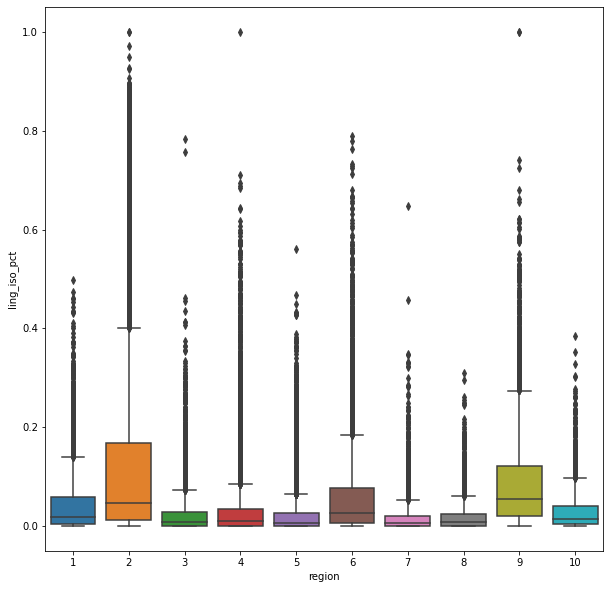

In [224]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['ling_iso_pct']);

In [225]:
env.groupby('region')['under_5_pct'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,0.050642,0.021941,0.0,0.036499,0.048406,0.063154,0.187500
2,7720.0,0.056379,0.027759,0.0,0.038504,0.053069,0.070366,0.323529
3,7336.0,0.057013,0.025086,0.0,0.040899,0.054150,0.070472,0.365672
4,13796.0,0.057061,0.026480,0.0,0.039753,0.055263,0.071818,0.251805
5,13035.0,0.059481,0.024981,0.0,0.043633,0.057079,0.072866,0.301959
6,8575.0,0.066549,0.027284,0.0,0.048417,0.064567,0.082406,0.224619
7,3501.0,0.062602,0.023289,0.0,0.047704,0.060653,0.075157,0.214760
8,2655.0,0.063344,0.027195,0.0,0.044974,0.061159,0.080054,0.242812
9,10512.0,0.059997,0.027258,0.0,0.041871,0.058543,0.076270,0.320000


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


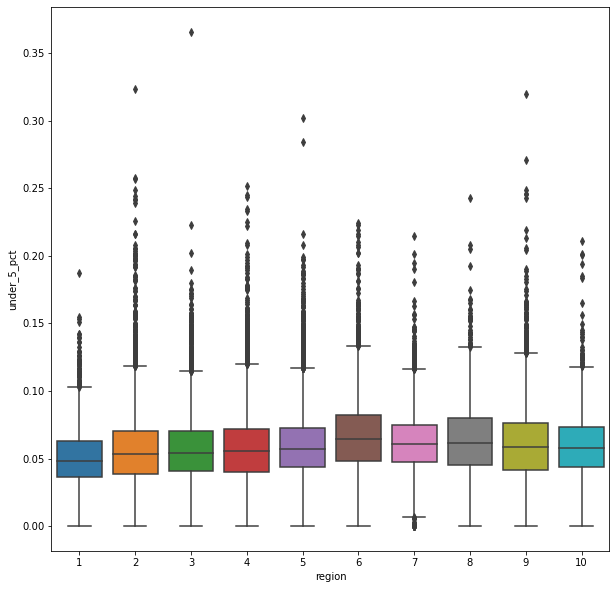

In [226]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['under_5_pct']);

In [227]:
env.groupby('region')['over_64_pct'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,0.172922,0.067576,0.0,0.129906,0.168621,0.209515,0.687500
2,7720.0,0.167339,0.073310,0.0,0.121859,0.161279,0.201897,0.922115
3,7336.0,0.169327,0.071154,0.0,0.121902,0.168222,0.211648,0.892591
4,13796.0,0.180047,0.099941,0.0,0.123457,0.164664,0.208599,0.880767
5,13035.0,0.163847,0.064726,0.0,0.120619,0.162038,0.200664,0.572774
6,8575.0,0.144939,0.066823,0.0,0.098758,0.139508,0.182667,0.846806
7,3501.0,0.167188,0.060169,0.0,0.126801,0.168394,0.206292,0.454112
8,2655.0,0.149077,0.071086,0.0,0.096407,0.142208,0.191289,0.827849
9,10512.0,0.155936,0.099230,0.0,0.095235,0.135481,0.189959,0.912525


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


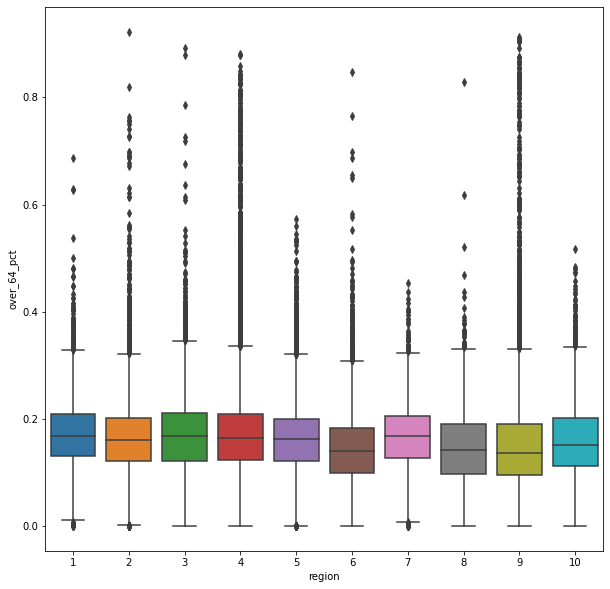

In [228]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['over_64_pct']);

In [229]:
env.groupby('region')['pre_1960_pct'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,0.462093,0.221880,0.0,0.282438,0.442815,0.646154,1.000000
2,7720.0,0.490736,0.270499,0.0,0.268462,0.502460,0.726739,1.000000
3,7336.0,0.388812,0.274680,0.0,0.150264,0.343042,0.620892,1.000000
4,13796.0,0.174125,0.182977,0.0,0.036176,0.116595,0.238914,0.977667
5,13035.0,0.418714,0.264194,0.0,0.197972,0.386496,0.635658,1.000000
6,8575.0,0.205053,0.215849,0.0,0.032029,0.128637,0.309729,1.000000
7,3501.0,0.375756,0.253535,0.0,0.147860,0.368461,0.574307,1.000000
8,2655.0,0.232575,0.228561,0.0,0.034925,0.158046,0.384829,0.949060
9,10512.0,0.261193,0.254783,0.0,0.030849,0.176574,0.452385,0.976869


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


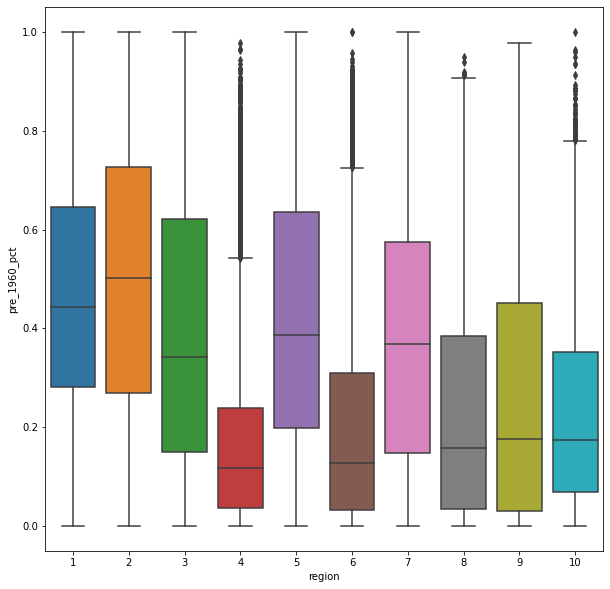

In [230]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['pre_1960_pct']);

In [231]:
env.groupby('region')['unemp_pct'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
1,3357.0,0.052061,0.037905,0.0,0.029085,0.043679,0.063924,0.564103
2,7720.0,0.071591,0.065095,0.0,0.034006,0.052705,0.083849,0.720982
3,7336.0,0.056520,0.041817,0.0,0.029727,0.045876,0.070743,0.473684
4,13796.0,0.062106,0.044008,0.0,0.032362,0.052165,0.079743,0.555556
5,13035.0,0.060703,0.054025,0.0,0.027726,0.044872,0.073719,1.000000
6,8575.0,0.057641,0.040382,0.0,0.030730,0.048963,0.073720,0.546554
7,3501.0,0.043925,0.034490,0.0,0.021394,0.034848,0.056471,0.363462
8,2655.0,0.041323,0.032441,0.0,0.021085,0.035398,0.052577,0.356401
9,10512.0,0.062025,0.040456,0.0,0.035422,0.053749,0.079115,1.000000


C:\Users\Vishnu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


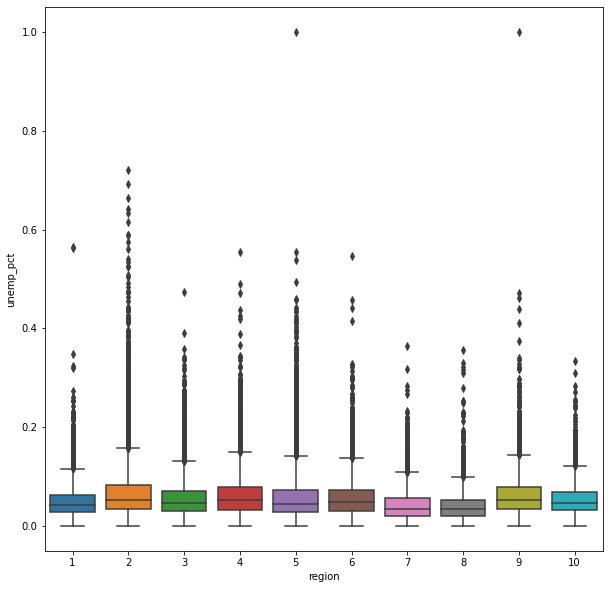

In [232]:
plt.figure(figsize = (10,10))
sns.boxplot(env['region'], env['unemp_pct']);

Environmental factors boxplot

In [233]:
env['cancer'].describe()

count    73219.000000
mean        28.511629
std         10.711776
min          8.000000
25%         20.000000
50%         30.000000
75%         30.000000
max       1000.000000
Name: cancer, dtype: float64

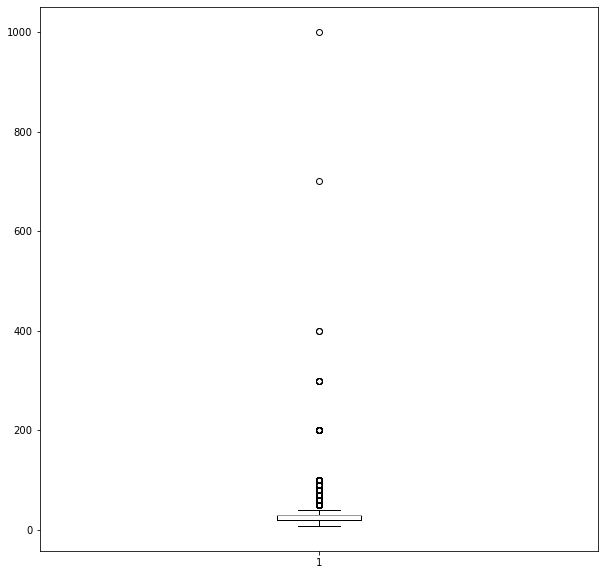

In [234]:
plt.figure(figsize = (10,10))
plt.boxplot(env['cancer']);

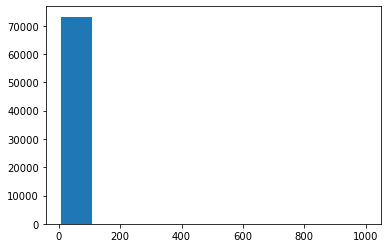

In [235]:
plt.hist(env['cancer']);

In [236]:
env['diesel_pm'].describe()

count    73219.000000
mean         0.299111
std          0.238228
min          0.000002
25%          0.139305
50%          0.244791
75%          0.383705
max          1.927320
Name: diesel_pm, dtype: float64

In [237]:
colors = ['pink']

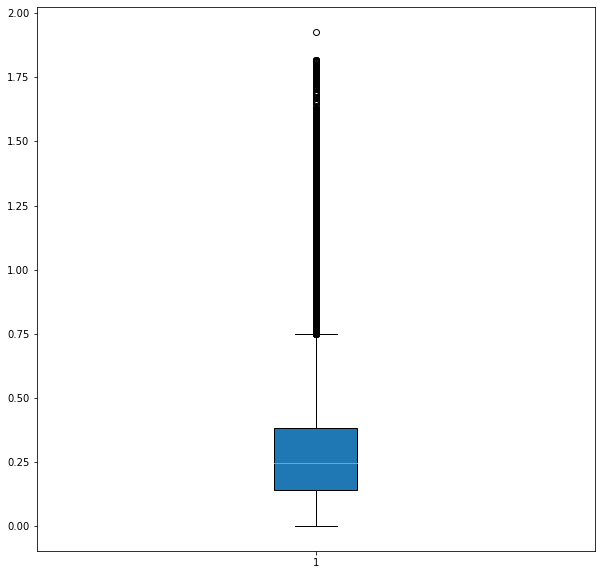

In [238]:
plt.figure(figsize = (10,10))
plt.boxplot(env['diesel_pm'], patch_artist=True);

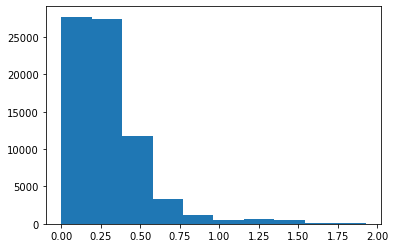

In [239]:
plt.hist(env['diesel_pm']);

In [240]:
env['resp_index'].describe()

count    73219.000000
mean         0.360005
std          0.133762
min          0.070000
25%          0.300000
50%          0.400000
75%          0.400000
max          5.000000
Name: resp_index, dtype: float64

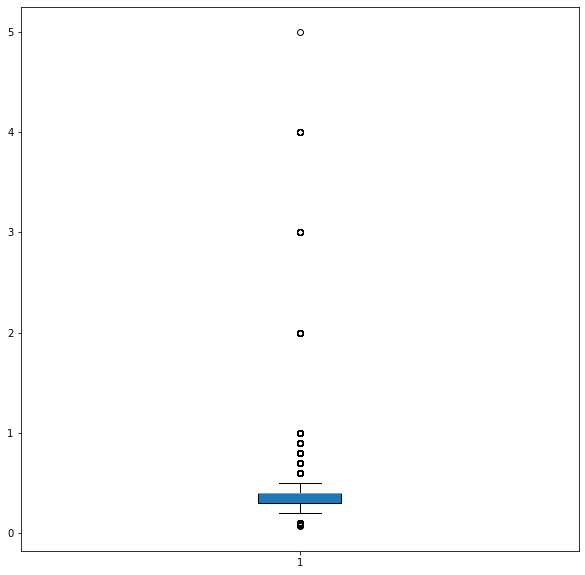

In [241]:
plt.figure(figsize = (10,10))
plt.boxplot(env['resp_index'], patch_artist=True);

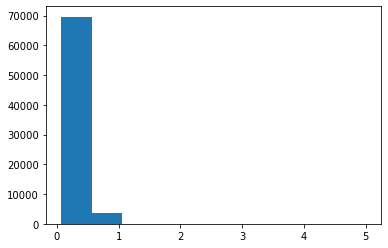

In [242]:
plt.hist(env['resp_index']);

In [243]:
env['npl_prox'].describe()

count    73219.000000
mean         0.135981
std          0.273878
min          0.001130
25%          0.027083
50%          0.061822
75%          0.133559
max          8.059139
Name: npl_prox, dtype: float64

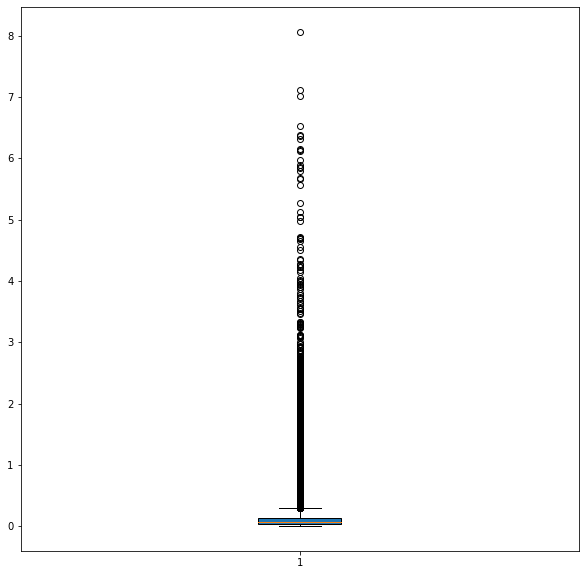

In [244]:
plt.figure(figsize = (10,10))
plt.boxplot(env['npl_prox'], patch_artist=True);

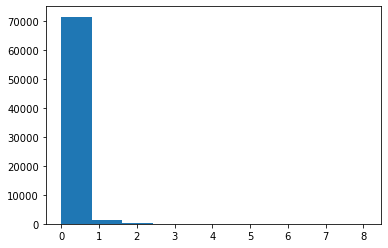

In [245]:
plt.hist(env['npl_prox']);

In [246]:
env['rmp_prox'].describe()

count    73219.000000
mean         0.800404
std          1.105838
min          0.001413
25%          0.148238
50%          0.366442
75%          1.033092
max         17.607654
Name: rmp_prox, dtype: float64

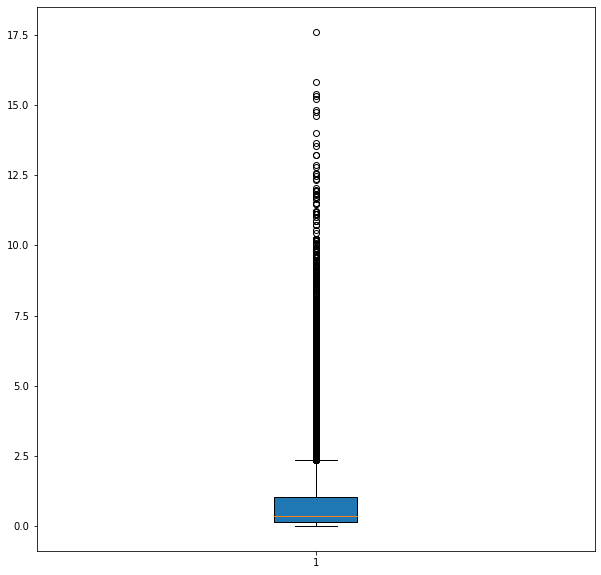

In [247]:
plt.figure(figsize = (10,10))
plt.boxplot(env['rmp_prox'], patch_artist=True);

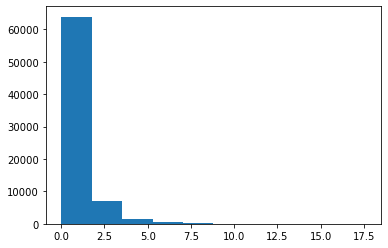

In [248]:
plt.hist(env['rmp_prox']);

In [249]:
env['waste_prox'].describe()

count    73219.000000
mean         2.254717
std          3.906192
min          0.001280
25%          0.160165
50%          0.791039
75%          2.646130
max         57.751593
Name: waste_prox, dtype: float64

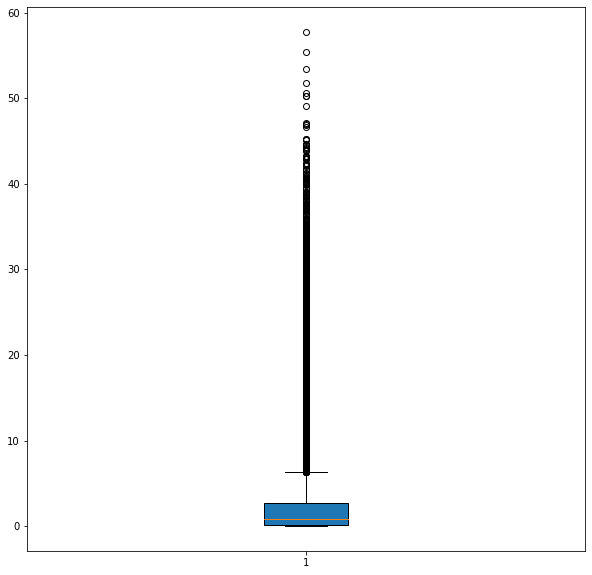

In [250]:
plt.figure(figsize = (10,10))
plt.boxplot( env['waste_prox'], patch_artist=True);

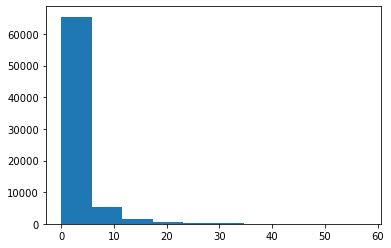

In [251]:
plt.hist(env['waste_prox']);

In [252]:
env['undgrd_stor'].describe()

count    73219.000000
mean         4.295767
std          7.265454
min          0.000000
25%          0.395179
50%          1.821258
75%          4.883952
max        154.788486
Name: undgrd_stor, dtype: float64

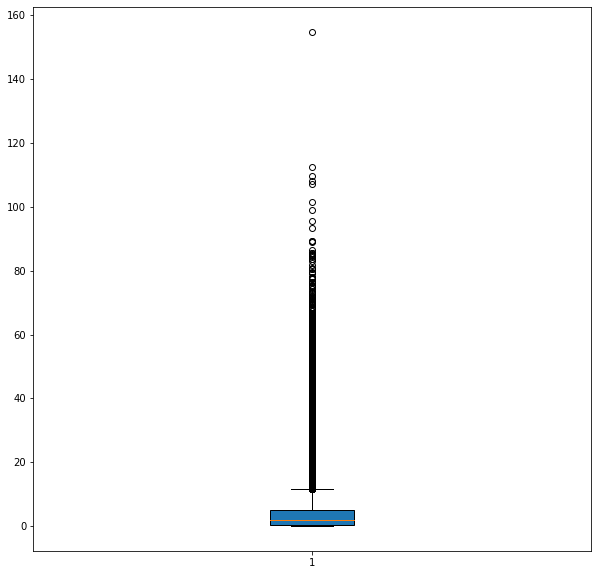

In [253]:
plt.figure(figsize = (10,10))
plt.boxplot(env['undgrd_stor'], patch_artist=True);

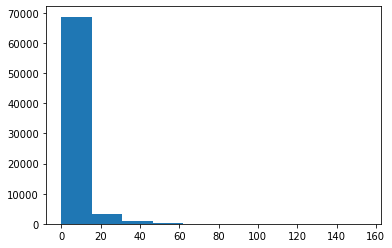

In [254]:
plt.hist(env['undgrd_stor']);

Demographic Index

In [255]:
env['pop'].describe()

count    73219.000000
mean      4479.741215
std       2313.963476
min         31.000000
25%       2941.000000
50%       4144.000000
75%       5570.000000
max      72041.000000
Name: pop, dtype: float64

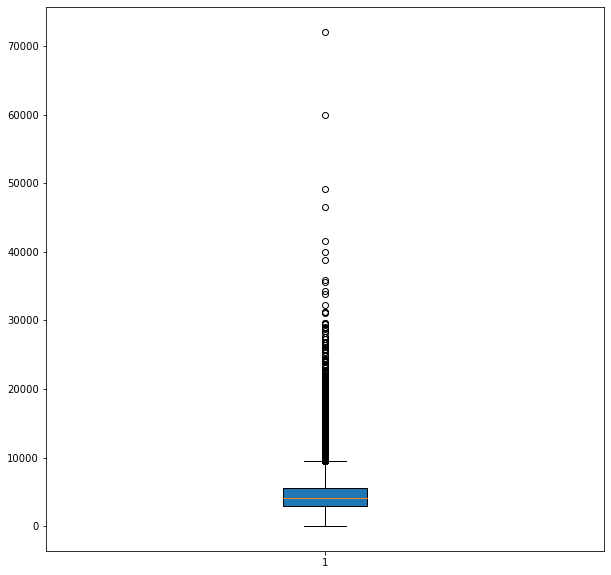

In [256]:
plt.figure(figsize = (10,10))
plt.boxplot(env['pop'], patch_artist=True);

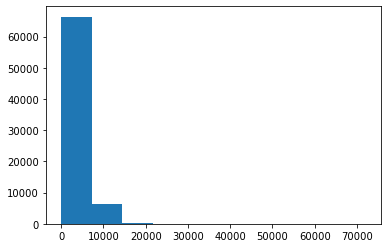

In [257]:
plt.hist(env['pop']);

In [258]:
env['poc_pct'].describe()

count    73219.000000
mean         0.394099
std          0.304841
min          0.000000
25%          0.130104
50%          0.309403
75%          0.628146
max          1.000000
Name: poc_pct, dtype: float64

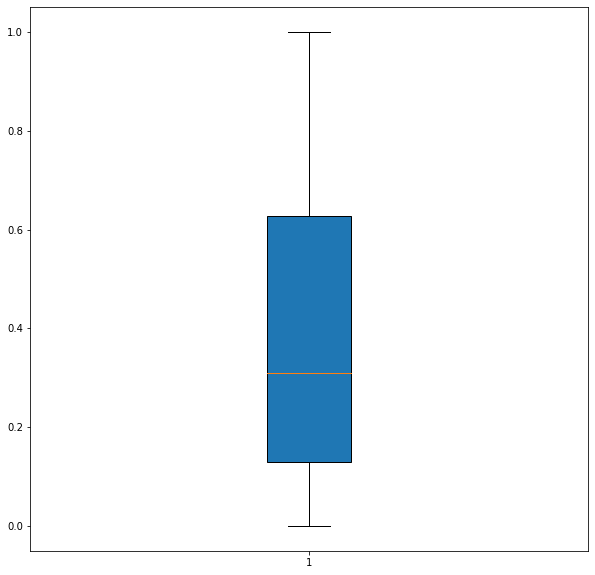

In [259]:
plt.figure(figsize = (10,10))
plt.boxplot(env['poc_pct'], patch_artist=True);

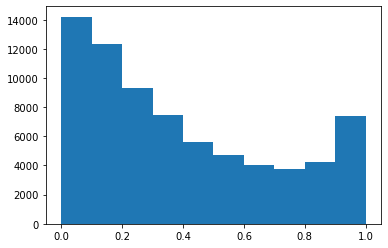

In [260]:
plt.hist(env['poc_pct']);

In [261]:
env['low_inc_pct'].describe()

count    73219.000000
mean         0.331081
std          0.187236
min          0.000000
25%          0.182592
50%          0.303790
75%          0.452309
max          1.000000
Name: low_inc_pct, dtype: float64

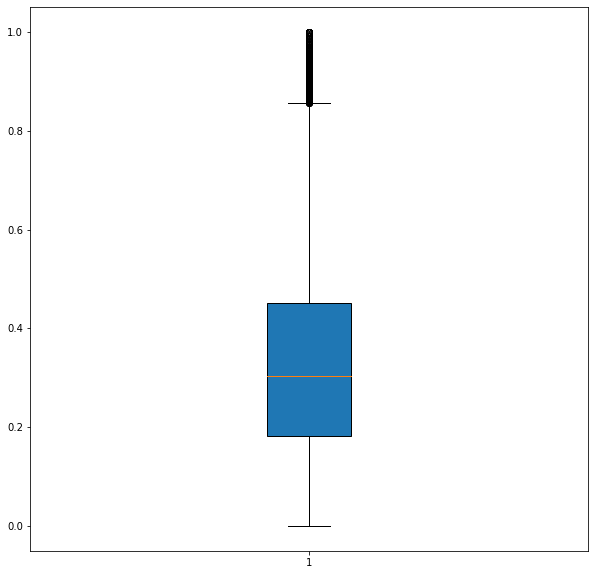

In [262]:
plt.figure(figsize = (10,10))
plt.boxplot(env['low_inc_pct'], patch_artist=True);

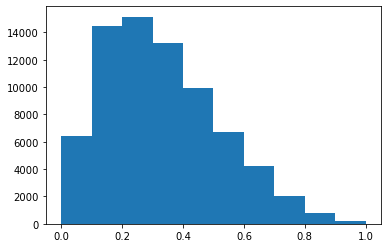

In [263]:
plt.hist(env['low_inc_pct']);

In [264]:
env['sub_hs_pct'].describe()

count    73219.000000
mean         0.127884
std          0.103999
min          0.000000
25%          0.052842
50%          0.099011
75%          0.173580
max          1.000000
Name: sub_hs_pct, dtype: float64

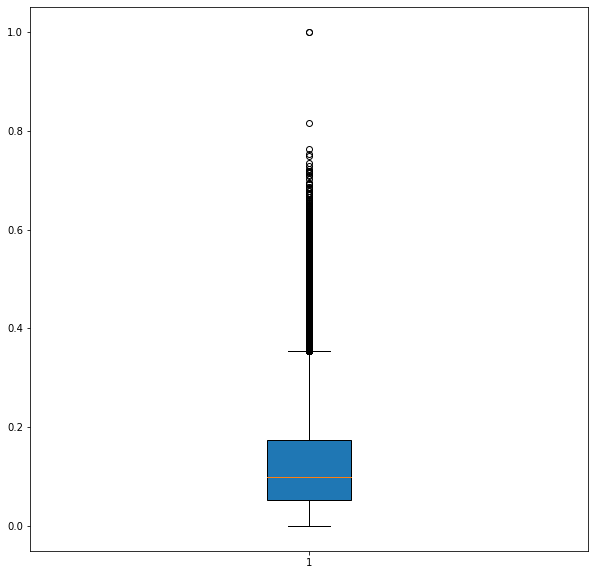

In [265]:
plt.figure(figsize = (10,10))
plt.boxplot(env['sub_hs_pct'], patch_artist=True);

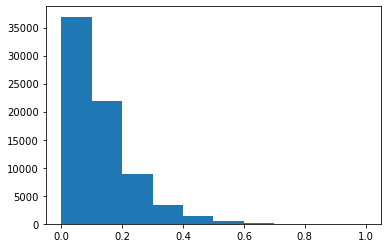

In [266]:
plt.hist(env['sub_hs_pct']);

In [267]:
env['ling_iso_pct'].describe()

count    73219.000000
mean         0.053338
std          0.103814
min          0.000000
25%          0.000000
50%          0.016507
75%          0.055862
max          1.000000
Name: ling_iso_pct, dtype: float64

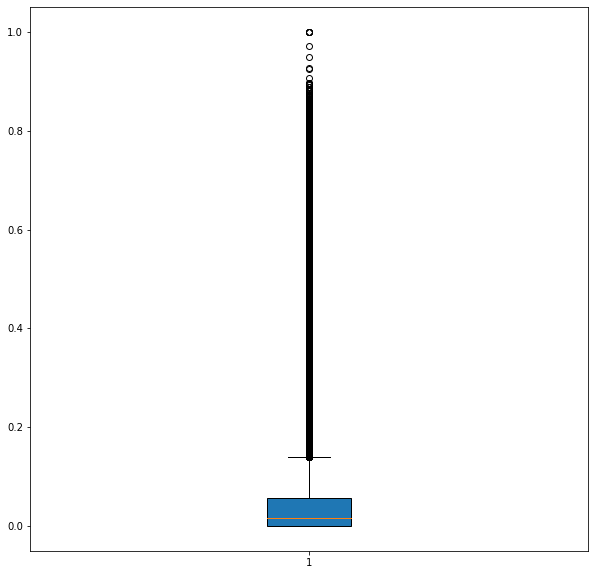

In [268]:
plt.figure(figsize = (10,10))
plt.boxplot(env['ling_iso_pct'], patch_artist=True);

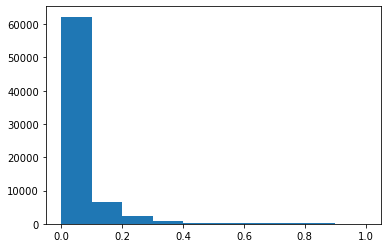

In [269]:
plt.hist(env['ling_iso_pct']);

In [270]:
env['under_5_pct'].describe()

count    73219.000000
mean         0.059222
std          0.026282
min          0.000000
25%          0.042103
50%          0.057013
75%          0.073895
max          0.365672
Name: under_5_pct, dtype: float64

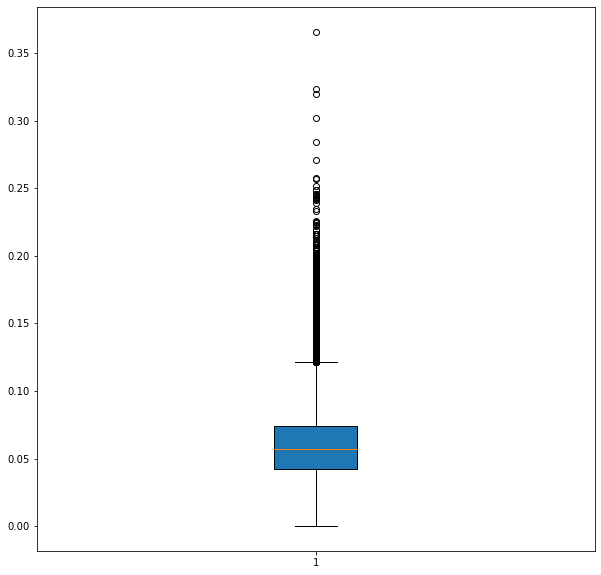

In [271]:
plt.figure(figsize = (10,10))
plt.boxplot(env['under_5_pct'], patch_artist=True);

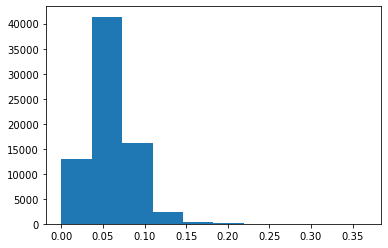

In [272]:
plt.hist(env['under_5_pct']);

In [273]:
env['over_64_pct'].describe()

count    73219.000000
mean         0.164473
std          0.080672
min          0.000000
25%          0.113605
50%          0.156958
75%          0.200876
max          0.922115
Name: over_64_pct, dtype: float64

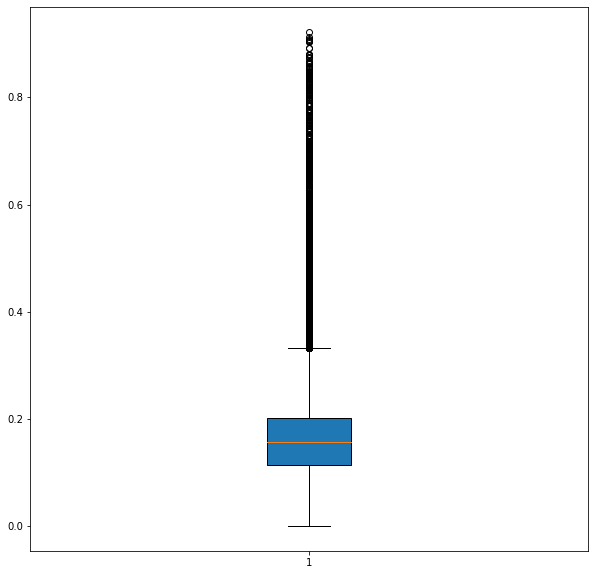

In [274]:
plt.figure(figsize = (10,10))
plt.boxplot(env['over_64_pct'], patch_artist=True);

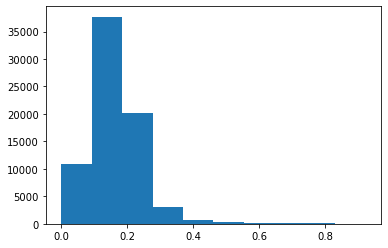

In [275]:
plt.hist(env['over_64_pct']);

In [276]:
env['unemp_pct'].describe()

count    73219.000000
mean         0.059382
std          0.046701
min          0.000000
25%          0.030141
50%          0.047967
75%          0.074039
max          1.000000
Name: unemp_pct, dtype: float64

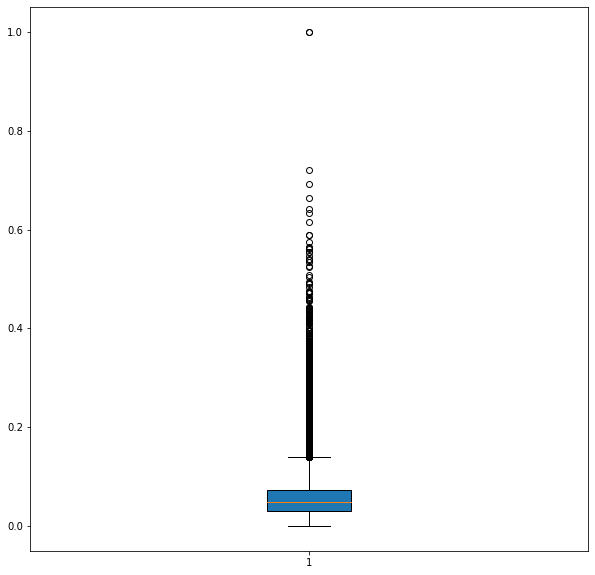

In [277]:
plt.figure(figsize = (10,10))
plt.boxplot(env['unemp_pct'], patch_artist=True);

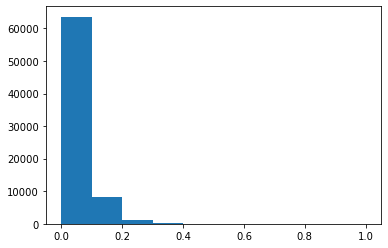

In [278]:
plt.hist(env['unemp_pct']);

In [279]:
env['pre_1960_pct'].describe()

count    73219.000000
mean         0.316033
std          0.265660
min          0.000000
25%          0.078189
50%          0.250330
75%          0.511885
max          1.000000
Name: pre_1960_pct, dtype: float64

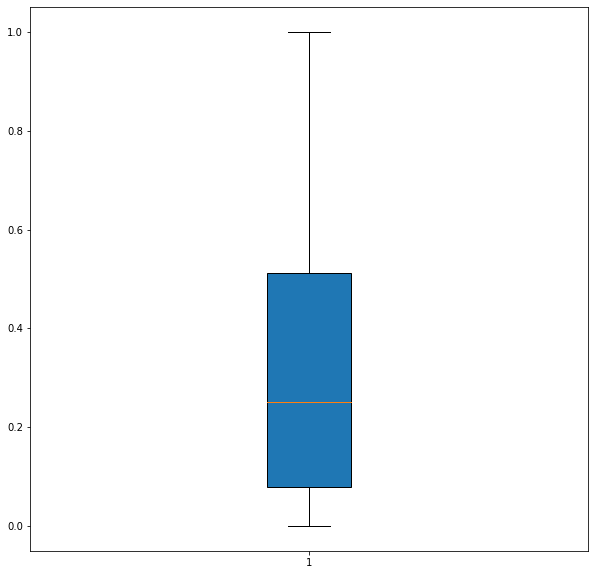

In [280]:
plt.figure(figsize = (10,10))
plt.boxplot(env['pre_1960_pct'], patch_artist=True);

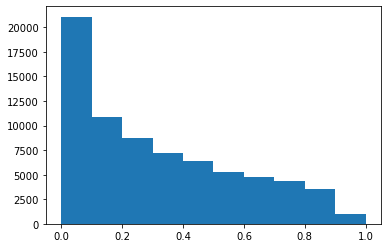

In [281]:
plt.hist(env['pre_1960_pct']);

---

## Imputing

In [282]:
cols_to_impute = ['traffic_prox', 'ozone', 'pm_25']

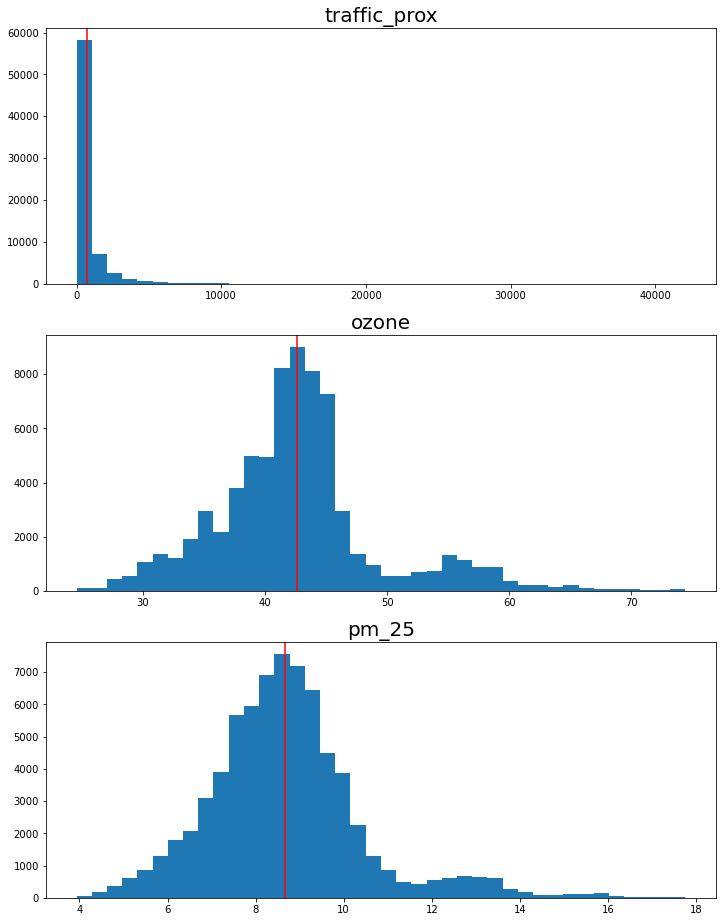

In [283]:
plt.figure(figsize = (12,16))

for i in range(3):
    plt.subplot(3,1,i+1)
    col_name = cols_to_impute[i]
    plt.title(f'{col_name}', size = 20)
    plt.hist(env[col_name], bins = 40)
    plt.axvline(env[col_name].mean(), color = 'red')
    

In [284]:
# may want to one-hot-encode region to impute using regression 
X = env.drop(columns = ['cancer', 'st_name', 'st_abbrev'])
y = env['cancer']

In [285]:
X_train, X_val, Y_train, Y_val = train_test_split(X,y, test_size = 0.2, random_state = 13)

In [286]:
it = IterativeImputer(estimator = LinearRegression())
X_train_missing = it.fit_transform(X_train)
X_val_missing = it.transform(X_val)

X_train_imputed = pd.DataFrame(X_train_missing, columns = it.get_feature_names_out())
X_val_imputed = pd.DataFrame(X_val_missing, columns = it.get_feature_names_out())

In [287]:
X_imputed = pd.concat([X_train_imputed, X_val_imputed])

In [288]:
X_imputed

,region,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,unemp_pct,pre_1960_pct,diesel_pm,resp_index,traffic_prox,npl_prox,rmp_prox,waste_prox,ozone,pm_25,undgrd_stor
0,2.0,4045.0,0.401236,0.259727,0.143237,0.044361,0.038072,0.164400,0.060688,0.361671,0.305874,0.3,244.094471,0.125307,0.086791,1.313213,43.804595,7.439898,1.680509
1,2.0,5118.0,0.161782,0.127372,0.033595,0.037461,0.052755,0.203204,0.036295,0.547035,0.277527,0.3,402.408271,0.092864,0.228712,0.414198,42.045325,7.491417,10.711699
2,3.0,2550.0,0.506667,0.643683,0.226740,0.021075,0.151765,0.049020,0.099571,0.302785,0.254800,0.3,885.145986,0.172876,1.160913,0.825702,44.921961,7.734490,1.203185
3,6.0,2637.0,0.098976,0.511407,0.250522,0.035680,0.086841,0.139173,0.033569,0.098077,0.060401,0.5,0.026620,0.408759,0.128420,0.028133,38.430395,8.820738,0.024831
4,7.0,4208.0,0.284696,0.321530,0.049782,0.028432,0.060837,0.123099,0.070169,0.874308,0.579414,0.5,1055.238398,0.116735,0.517442,3.335104,48.547152,9.451945,3.032293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14639,6.0,4072.0,0.421169,0.430723,0.224621,0.029172,0.095776,0.154715,0.081924,0.439952,0.113892,0.4,48.350477,0.029632,0.871878,0.040546,39.027198,9.488393,1.539221
14640,1.0,5151.0,0.055911,0.143394,0.073560,0.010501,0.039410,0.221510,0.060544,0.248111,0.123280,0.2,117.476119,0.042640,0.045132,0.892260,41.704182,6.029829,0.850917
14641,5.0,2834.0,0.938250,0.418630,0.063304,0.004596,0.087509,0.086097,0.105263,0.821567,0.324143,0.3,1445.048769,0.144207,0.577823,1.428223,45.089852,9.920975,30.780750
14642,5.0,6648.0,0.340704,0.458847,0.081584,0.006780,0.096871,0.101384,0.054037,0.231471,0.345399,0.3,394.387992,0.236663,1.607285,0.945679,47.107778,10.104725,1.763924


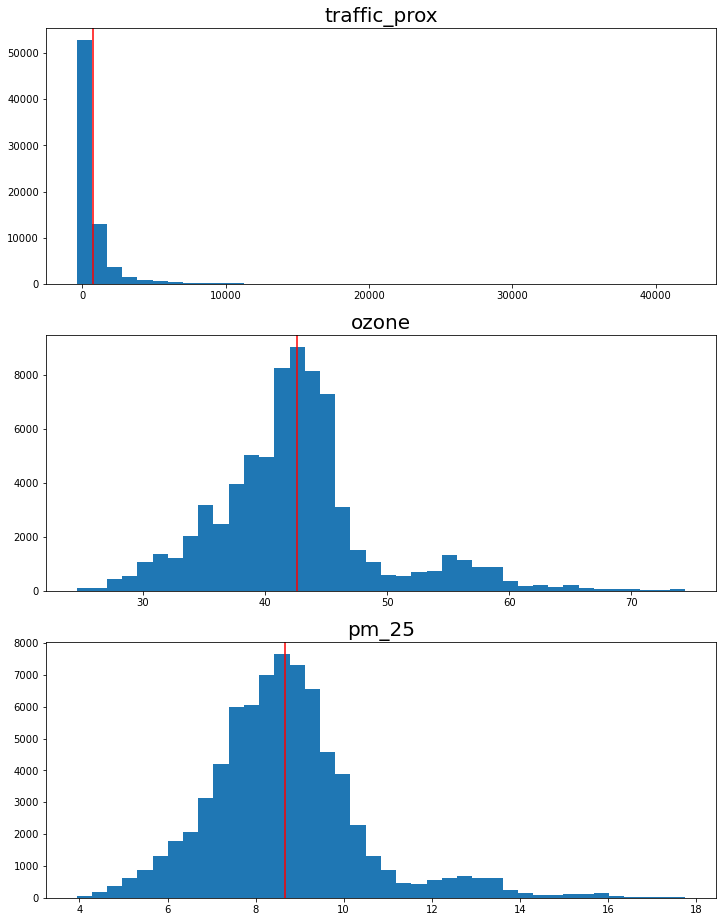

In [289]:
cols_to_impute_2 = ['traffic_prox', 'ozone', 'pm_25']

plt.figure(figsize = (12,16))

for i in range(3):
    plt.subplot(3,1,i+1)
    col_name = cols_to_impute_2[i]
    plt.title(f'{col_name}', size = 20)
    plt.hist(X_imputed[col_name], bins = 40)
    plt.axvline(X_imputed[col_name].mean(), color = 'red')
    

---

## For the Team

Below is code showing that if we drop the null values outside of `waste_water`, we eliminate Puerto Rico, Hawaii, and Alaska from the entire dataset. These three territories seem to only be missing `ozone` and `pm_25` data.

In [290]:
# collect rows where there are any missing values
# besides waste_water with 20,000 missing values

# na_rows are the incdices of null values
# has_na is the dataset containing null
na_rows = env.select_dtypes(include = 'number').drop(columns = ['waste_water']).isna().any(axis = 1)
has_na = env[na_rows]

KeyError: "['waste_water'] not found in axis"

In [291]:
# 10 states with the most null values in the dataset currently
null_states = has_na['st_abbrev'].value_counts().head(10).index
has_na['st_abbrev'].value_counts().head(10)

NameError: name 'has_na' is not defined

In [292]:
# the total number of appearances of these states in the entire dataset
env['st_abbrev'].value_counts()[null_states]

NameError: name 'null_states' is not defined

Another thing to note about these three groups is that their nulls are primarily located in in the `ozone` and `pm_25` columns.

In [293]:
for territory in ['PR', 'HI', 'AK']:
    print(territory)
    print(env[env['st_abbrev'] == territory].isnull().sum(), '\n\n')

PR
st_name           0
st_abbrev         0
region            0
pop               0
poc_pct           0
low_inc_pct       0
sub_hs_pct        0
ling_iso_pct      0
under_5_pct       0
over_64_pct       0
unemp_pct         0
pre_1960_pct      0
diesel_pm         0
cancer            0
resp_index        0
traffic_prox      7
npl_prox          0
rmp_prox          0
waste_prox        0
ozone           884
pm_25           884
undgrd_stor       0
dtype: int64 


HI
st_name           0
st_abbrev         0
region            0
pop               0
poc_pct           0
low_inc_pct       0
sub_hs_pct        0
ling_iso_pct      0
under_5_pct       0
over_64_pct       0
unemp_pct         0
pre_1960_pct      0
diesel_pm         0
cancer            0
resp_index        0
traffic_prox      9
npl_prox          0
rmp_prox          0
waste_prox        0
ozone           313
pm_25           313
undgrd_stor       0
dtype: int64 


AK
st_name           0
st_abbrev         0
region            0
pop               0

----